## 0. Libarary 불러오기 및 경로설정

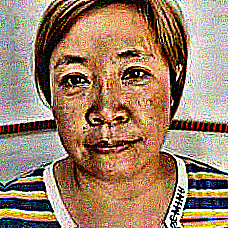

In [218]:
from PIL import Image
# from torchvision import transforms
import albumentations as A
import numpy as np
a = np.array(Image.open('/opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg'))

# tmp = A.Equalize(always_apply=True),
# tmp = A.(always_apply=True)
# A.Solarize(threshold=128,always_apply=True)

tmp = A.Compose([
            A.CenterCrop(228,228,always_apply=True),
            A.CLAHE(clip_limit = 3,always_apply=True),
            A.ColorJitter(0.1,0.4,0.1,0,always_apply=True),
            A.FancyPCA(alpha = 0.05,always_apply=True),
            A.GaussNoise(var_limit = 100,always_apply=True),
            A.RandomFog(fog_coef_lower=0.01,fog_coef_upper=0.2,always_apply=True),
            A.ShiftScaleRotate(shift_limit= 0.02, scale_limit= 0, rotate_limit=6,always_apply=True),
            A.Sharpen(alpha = (1.0,1.0), lightness=(0.8,1),always_apply=True)
])



a = Image.fromarray(tmp(image = a)['image'])
a


#0.7,0.4,0.1,0





In [219]:
!pip install grad-cam


     |████████████████████████████████| 4.5 MB 14.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=12cdcfab077664cda8f6075ecbba62f95bb46f755407287ba66c8a60d4bd5e97
  Stored in directory: /opt/ml/.cache/pip/wheels/b2/71/4c/03778c17c8f0341b1ed9aca0f504c40be2af14be266e7ecee6
Successfully built grad-cam


In [222]:
import timm
from torchvision import models
# a = timm.list_models('*efficientnet*',pretrained=True)
a = models.resnet50()
# a = timm.create_model('efficientnet_b3_pruned')
a

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
import torchvision.models as models
from tqdm.notebook import tqdm

In [ ]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
train_dir = '/opt/ml/input/data/train'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

cuda:0


## 1. Model 정의

In [ ]:
net = models.resnet152(pretrained=True)

In [ ]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
net.fc = torch.nn.Linear(in_features=2048, out_features=18, bias=True)
net.to(device)
LEARNING_RATE = 0.0001
NUM_EPOCH = 1
loss_fn = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
torch.nn.init.xavier_uniform_(net.fc.weight)

Parameter containing:
tensor([[-3.6353e-02,  1.6341e-02, -3.7548e-02,  ...,  1.2263e-02,
         -1.8796e-02,  2.3467e-02],
        [ 4.9904e-02,  9.9363e-05,  2.1137e-02,  ..., -1.9102e-02,
          3.8218e-02, -2.2411e-02],
        [-2.6412e-02, -3.7319e-02,  5.1819e-02,  ...,  2.3780e-02,
          1.8305e-02,  3.5122e-03],
        ...,
        [ 3.1819e-02,  9.1800e-04, -8.3958e-03,  ...,  3.8235e-02,
          1.5562e-02,  2.8247e-02],
        [-5.1530e-02, -3.3707e-02, -5.2399e-02,  ...,  5.2249e-02,
         -1.2428e-02,  2.6584e-02],
        [-4.0263e-03,  3.7076e-02,  4.9270e-02,  ...,  3.6599e-02,
          4.1209e-02, -2.3993e-02]], device='cuda:0', requires_grad=True)

## 2. Train Dataset 정의

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, train_path, transform):
        img_path = os.path.join(train_path, 'images')
        self.transform = transform
        self.traininfo = pd.read_csv(os.path.join(train_path, 'train.csv'))
        img_paths = img_path + '/' + self.traininfo['path']
        file_names = []
        for path in img_paths:
            names = os.listdir(path)
            names = [name for name in names if name[0] != '.']
            file_names.append(names)

        self.X = []
        self.Y = []
        for i in range(len(self.traininfo['path'])):
            for name in file_names[i]:
                self.X.append(os.path.join(img_paths[i], name))
                self.Y.append(self._classify(name[0],self.traininfo['gender'][i],self.traininfo['age'][i]))

    def __getitem__(self, index):
        image = Image.open(self.X[index])
        if self.transform:
            image = self.transform(image)
        target = self.Y[index]
        return image, target

    def _classify(self, mask, gender, age):
        t = torch.zeros(18)
        if age < 30 :
            c = 0
        elif 30 <= age < 60:
            c = 1
        else:
            c = 2

        if gender == 'female':
            c += 3

        if mask == 'i':
            c += 6
        elif mask == 'n':
            c += 12
        t[c] = 1
        return c

    def __len__(self):
        return len(self.X) 

In [ ]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
mask_train = TrainDataset(train_dir,transform)
mask_train[0]

(tensor([[[ 1.7157,  1.7157,  1.7157,  ...,  1.5000,  1.3824,  1.2843],
          [ 1.7157,  1.7157,  1.7157,  ...,  1.5000,  1.3824,  1.2843],
          [ 1.7157,  1.7157,  1.7157,  ...,  1.4804,  1.3627,  1.2647],
          ...,
          [ 0.9118,  0.8922,  0.8725,  ...,  1.1667,  1.1275,  1.1078],
          [ 0.8922,  0.8922,  0.8725,  ...,  0.8725,  0.8137,  0.7941],
          [ 0.8922,  0.8922,  0.8725,  ...,  0.4412,  0.3627,  0.3235]],
 
         [[ 1.6961,  1.6961,  1.6961,  ...,  1.5196,  1.4020,  1.3039],
          [ 1.6961,  1.6961,  1.6961,  ...,  1.5196,  1.4020,  1.3039],
          [ 1.6961,  1.6961,  1.6961,  ...,  1.5000,  1.3824,  1.2843],
          ...,
          [-0.0098, -0.0294, -0.0686,  ...,  0.1275,  0.0882,  0.0686],
          [-0.0294, -0.0294, -0.0686,  ..., -0.1667, -0.2255, -0.2451],
          [-0.0294, -0.0294, -0.0686,  ..., -0.5980, -0.6765, -0.7157]],
 
         [[ 1.6176,  1.6176,  1.6176,  ...,  1.4216,  1.3039,  1.2059],
          [ 1.6176,  1.6176,

In [ ]:
np.array(mask_train[0][1]).shape

()

In [ ]:
BATCH_SIZE = 24
mask_dataloader = torch.utils.data.DataLoader(mask_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## 3. Train

In [ ]:
best_test_accuracy = 0.
best_test_loss = 9999.
for epoch in range(NUM_EPOCH):
  running_loss = 0.
  running_acc = 0.
  net.train()
  for ind, (images, labels) in enumerate(mask_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함
    logits = net(images)
    _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함 
    loss = loss_fn(logits, labels)
    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
    optimizer.step() # 계산된 gradient를 가지고 모델 업데이트
    running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
    running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장
  # 한 epoch이 모두 종료되었을 때,
  epoch_loss = running_loss / len(mask_dataloader.dataset)
  epoch_acc = running_acc / len(mask_dataloader.dataset)
  print(f"현재 epoch-{epoch}의 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
  if best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
    best_test_accuracy = epoch_acc
  if best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
    best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 31.75 GiB total capacity; 14.16 GiB already allocated; 52.50 MiB free; 14.49 GiB reserved in total by PyTorch)

## 4.Inference

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
test_dir = '/opt/ml/input/data/eval'

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
net.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = net(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
